### COMPUTER VISION MODEL

IMPORTING MODULES

In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torchmetrics
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from helper_functions import plot_decision_boundary

from timeit import default_timer as timer

from tqdm.auto import tqdm

DOWNLOADING HELPER_FUNCTIONS

In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Helper functions are already installed")
else:
    print("Downloading helper functions")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open ("helper_functions.py", "wb") as f:
        f.write(request.content)

Helper functions are already installed


HYPERPARAMETERS

In [22]:
RANDOM_SEED = 42
BATCH_SIZE = 32
LEARNING_RATE = 0.1
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Currently using device: {DEVICE}")

Currently using device: cpu


TIMING FUNCTION

In [23]:
def train_time(start: float, end: float, device: torch.device = None) -> float:
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f}s")
    return total_time

TRAINING AND TESTING FUNCTIONS

In [24]:
def train_step(model: torch.nn.Module,
               train_data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy__fn: torchmetrics.Accuracy,
               device: torch.device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(train_data_loader):
        # Moving to DEVICE
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Forward pass
        y_pred = model(X)

        # Loss and acc
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy__fn(y_pred, y)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()
        
        # Optimizer step
        optimizer.step()

    # Calculate average loss and acc
    train_loss /= len(train_data_loader)
    train_acc /= len(train_data_loader)

    print(f"Training loss: {train_loss:.5f} | Training accuracy: {train_acc:.5f}")

def test_step(model: torch.nn.Module,
              test_data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in test_data_loader:
            # Send to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Loss and acc
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_pred, y)

        # Calculate average loss and acc
        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)

    print(f"Testing loss: {test_loss:.5f} | Testing accuracy: {test_acc:.5f}")

CREATING DATASET

In [25]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

LOOKING AT EXAMPLES

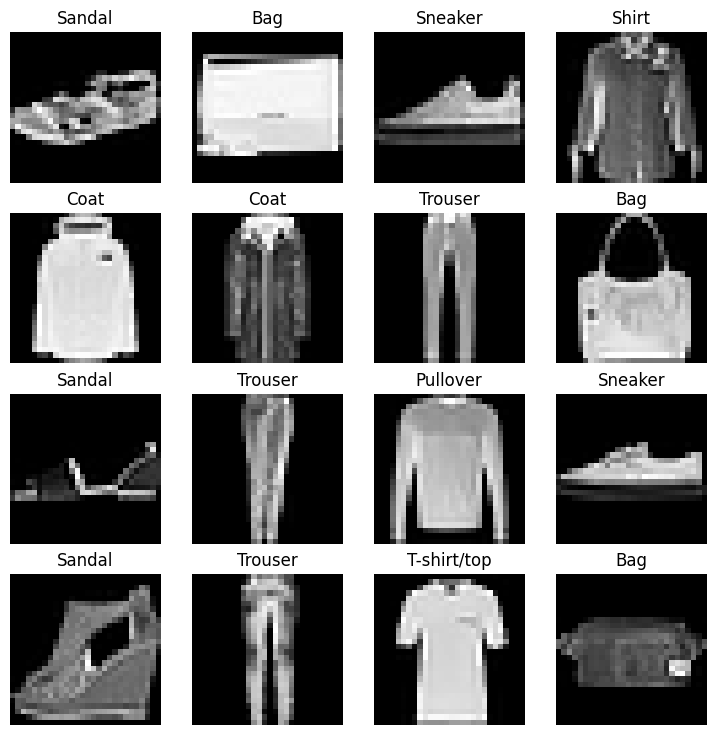

In [26]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)

CREATING MODEL

In [27]:
class FashionModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

INPUT_SHAPE = 1
HIDDEN_UNITS = 10
OUTPUT_SHAPE = len(train_data.classes)
model = FashionModel(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE).to(DEVICE)
model

FashionModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

SETTING LOSS FUNCTION, OPTIMIZER AND ACCURACY METRIC

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=LEARNING_RATE)
accuracy_fn = Accuracy(task="multiclass",
                    num_classes=len(train_data.classes)).to(DEVICE)

TRAINING AND TESTING LOOP

In [ ]:
time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n -----------")
    
    train_step(model, train_dataloader, loss_fn,
               optimizer, accuracy_fn, DEVICE)
    test_step(model, test_dataloader, loss_fn,
              optimizer, accuracy_fn, DEVICE)

time_end = timer()
train_time(time_start, time_end, DEVICE)

MAKING SAMPLE FROM INTERNET

torch.Size([1, 1, 28, 28])

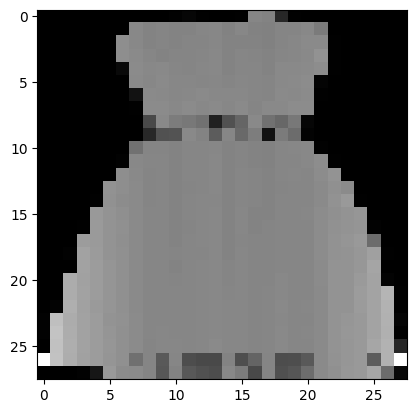

In [31]:
import cv2
import numpy as np
from PIL import Image

img = ~cv2.imread("2.webp")
img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
img = img[50:920,230:760]
img = cv2.resize(img, dsize=(28, 28), fx=1, fy=1)
# plt.imshow(img)

# fig = plt.figure(figsize=(20, 20))
# i, j = train_data[torch.randint(100, size=[1]).item()]
# fig.add_subplot(4, 4, 2)
# plt.imshow(i.squeeze(), cmap="gray")
# plt.title(train_data.classes[j])

img = torch.from_numpy(img).to(torch.float32).unsqueeze(0)
from torch.nn.functional import normalize
img = normalize(img, 5, 1)
fig.add_subplot(4, 4, 3)
plt.imshow(img.squeeze().squeeze(), cmap="gray")

img = img.unsqueeze(0)
img.shape

PREDICTING ON SAMPLE

In [32]:
model.eval()
with torch.inference_mode():
    img = img.to(DEVICE)
    pred = model(img)
thing = train_data.classes[pred.argmax(dim=1)]
print(f"I guess, this is a {thing.lower()}")

I guess, this is a dress


SAVING MODEL

In [30]:
torch.save(model, "MODEL_")

LOADING MODEL

In [29]:
model = torch.load("MODEL_", weights_only=False).to(DEVICE)
model

FashionModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)